# Fourier continuations of the third kind

This notebook implements Fourier continuations of the third kind with iterative refinement and overcollocation as explained in 

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">
<html lang="en">
<head>
<title>JabRef References output</title>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
<style type="text/css">
body { font-size: 12px; font-family: Arial, sans-serif; }
dt { margin-top: 1em; font-weight: bold; }
@media print {
	dt { page-break-after: avoid; }
	dd { page-break-before: avoid; }
}
</style>
</head>
<body>
<dl>
<dd>Boyd, J.P.</dd>
<dd><i>A comparison of numerical algorithms for Fourier extension of the first, second, and third kinds</i></dd>
<dd>Journal of Computational Physics, Elsevier, <b>2002</b>, Vol. 178(1), pp. 118-160</dd>

</dl>
</body>
</html>

Please forgive me for not documenting the code properly in the second half of the notebook. Variable naming is not consistent and there are many redefinitions. I provide that code so that interested readers have a working code example that they can adapt to their own needs. A class computing SVD extensions of arbitrary, complex functions can be found towards the end of the notebook. 

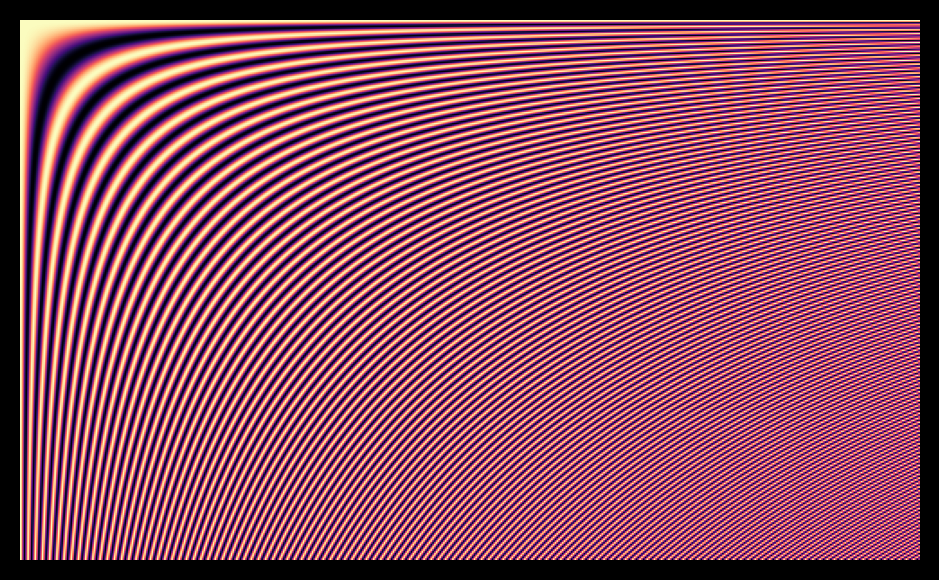

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

def get_fpic_su_matrix(N, Ncoll, theta, chi):
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N))
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1)
            M[i, j] = np.cos(j * np.pi / theta * x[i])
    return M, x

M, x  = get_fpic_su_matrix(N = 500, Ncoll = 300, theta = np.pi, chi = np.pi/2)

plt.style.use('dark_background')
fig, axs = plt.subplots(figsize=(5, 3), dpi=200)
plt.axis("off")
plt.imshow(M,  cmap="magma")
plt.tight_layout()
plt.savefig("figures/svd_W.png", bbox_inches='tight')
plt.show()

### Reproduce figure 8


NameError: name 'get_fpic_su_matrix' is not defined

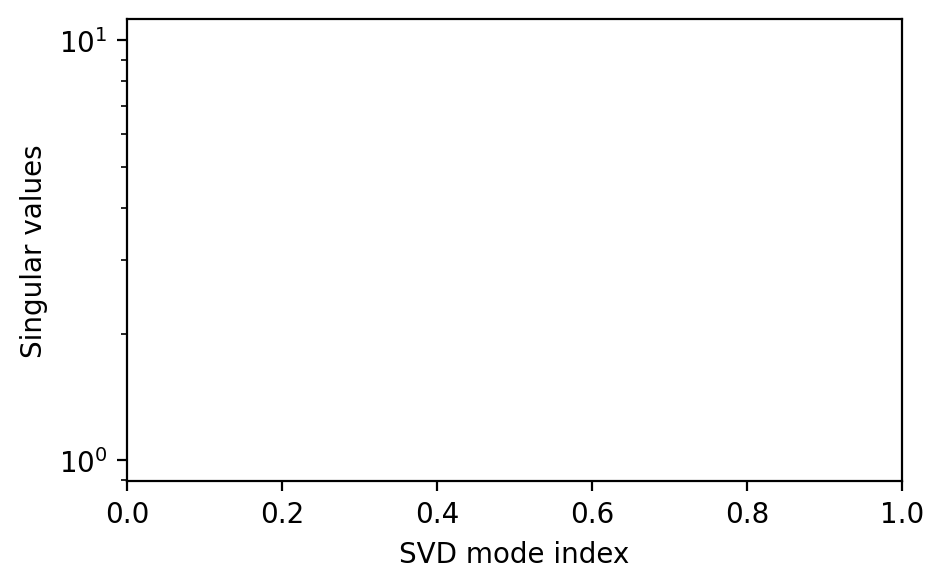

In [3]:

colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41', # matrix green
]

N     = 40
Ncoll = N

#The extended domain is split up into the physical and extension parts
#  [-theta, -chi, chi, theta]
theta = np.pi    # extension domain boundary
fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
#plt.title(f"FPIC-SU with N = {N}" + r" and $N_{coll}$" + f" = {Ncoll}")
plt.ylabel("Singular values")
plt.xlabel("SVD mode index")
plt.yscale("log")

chis   = [theta/4, theta/2, 3*theta/4]  # physical domain boundary
labels = [r"$\chi = \theta/4$", r"$\chi = \theta/2$", r"$\chi = 3\theta/4$"]

for i, (chi, label) in enumerate(zip(chis, labels)):
    M, x = get_fpic_su_matrix(N, Ncoll, theta, chi)
    y = scipy.linalg.svdvals(M, overwrite_a=False, check_finite=True)
    x = np.arange(len(y))
    plt.plot(x, y, label=label, c=colors[i])
plt.legend()
plt.tight_layout()
plt.savefig("figures/svd_fig_8.png", bbox_inches='tight')
plt.show()

## Compute the periodic extension of an even function ($f(x) = x^2$ in this example)

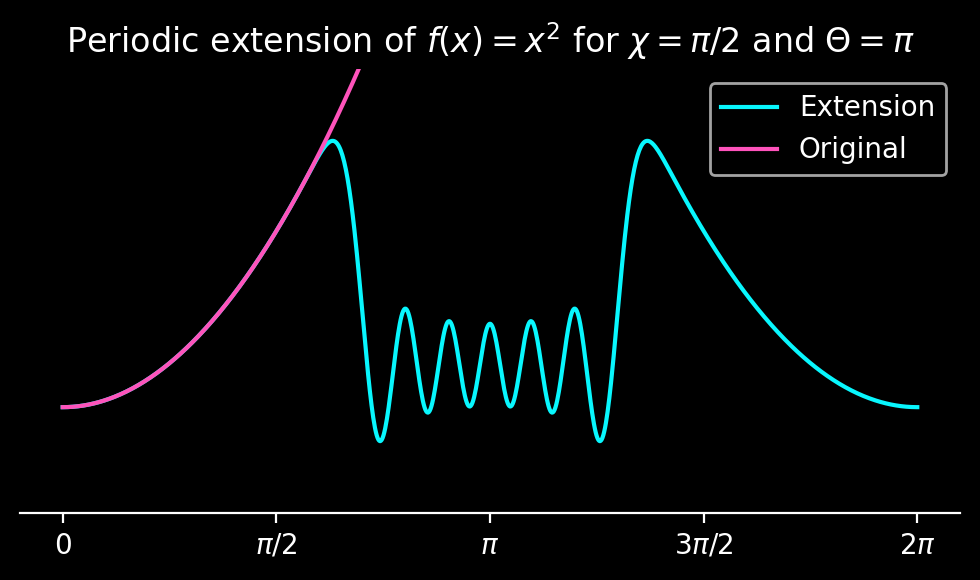

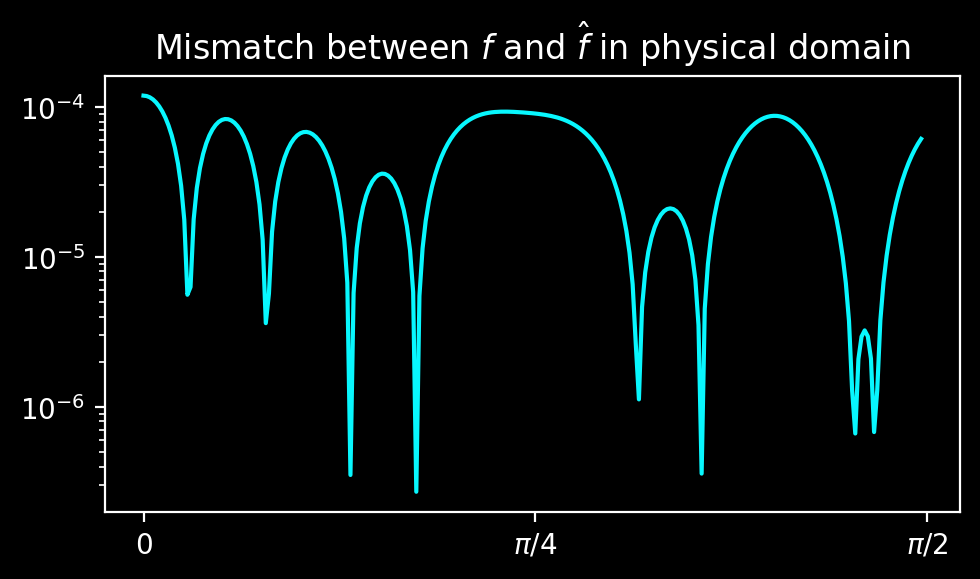

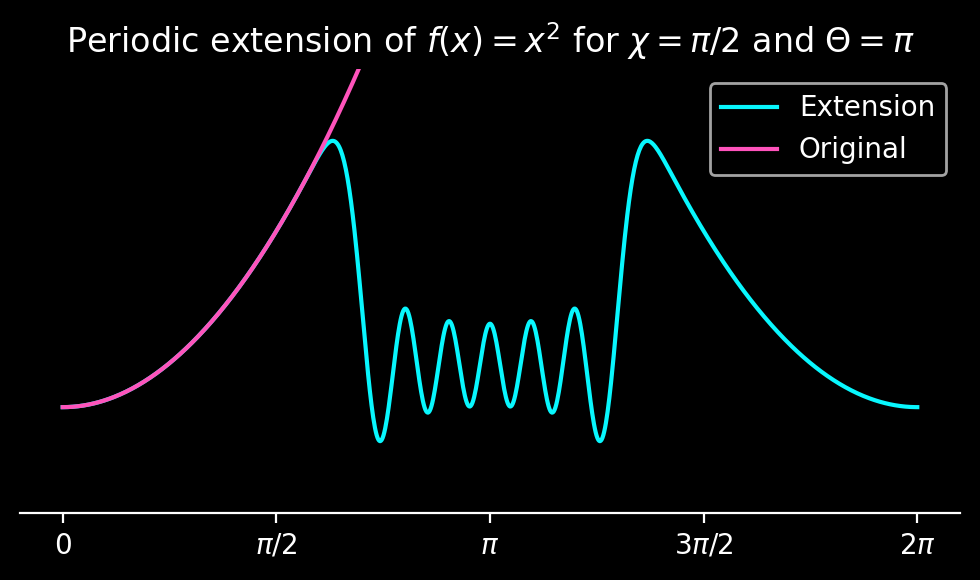

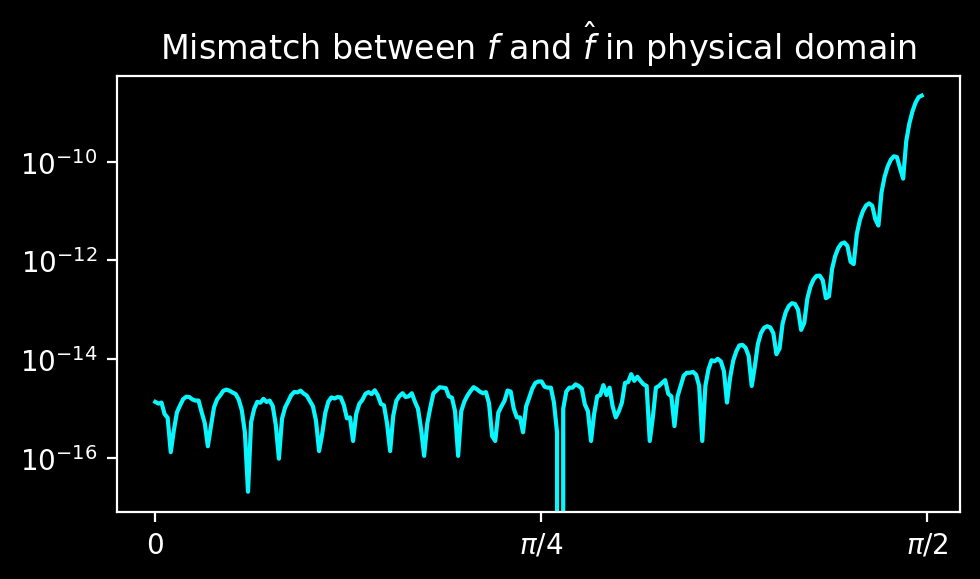

In [14]:
def func(x):
    return x**2

def truncated_svd_invert(M, cutoff):
    U, s, Vh = scipy.linalg.svd(M)
    sinv = np.zeros(M.T.shape)
    for i in range(np.min(M.shape)):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]
    return Vh.T @ sinv @ U.T

def iterative_refinement(M, Minv, f, threshold = 100, maxiter = 5):
    a       = Minv @ f
    r       = M @ a - f
    counter = 0
    while np.linalg.norm(r) > threshold * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter:
        delta    = Minv @ r
        a        = a - delta
        r        = M @ a - f
        counter += 1
    return a

def reconstruct(x, a, theta):
    rec = np.zeros(x.shape)
    for j, coeff in enumerate(a):
        rec += coeff * np.cos(np.pi / theta * j * x)
    return rec

N     = 32
Ncoll = N
theta = np.pi
chi   = theta/2
M, x  = get_fpic_su_matrix(N, Ncoll, theta, chi)
f     = func(x)
Minv  = truncated_svd_invert(M, cutoff = 1e-13)
a1    = Minv @ f
a2    = iterative_refinement(M, Minv, f, threshold = 1000, maxiter = 4)
xext  = np.linspace(0, 2 * theta, 1000)
frec1 = reconstruct(xext, a1, theta)
frec2 = reconstruct(xext, a2, theta)


for i, frec in enumerate([frec1, frec2]):
    # Plot f and extended f
    fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
    plt.title(r"Periodic extension of $f(x) = x^2$ for $\chi=\pi/2$ and $\Theta = \pi$")
    # Graphs
    plt.plot(xext, frec, label="Extension", c=colors[0])
    plt.plot(xext, func(xext), label="Original", c=colors[1])
    # Axes
    plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], [0, r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.get_yaxis().set_ticks([])
    # Save plot
    plt.tight_layout()
    plt.savefig(f"figures/svd_{i+1}.png", bbox_inches='tight')
    plt.legend()
    plt.show()

    # Plot error
    fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
    plt.title(r"Mismatch between $f$ and $\hat{f}$ in physical domain")
    # Physical domain
    ul = np.argwhere(xext<chi)[-1][0]
    xorg = xext[:ul]
    plt.yscale("log")
    plt.xticks([0, np.pi/4, np.pi/2], [0, r"$\pi/4$", r"$\pi/2$"])
    plt.plot(xorg, np.abs(func(xorg) - frec[:ul]), c=colors[0])
    plt.tight_layout()
    plt.savefig(f"figures/svd_{i+1}_accuracy.png", bbox_inches='tight')
    plt.show()

## Reproduce figure 9

In [15]:
def func2(x):
    return (3/4) * np.pi / (3/4 * np.pi - x) + (3/4) * np.pi / (3/4 * np.pi + x)

Ns    = np.arange(10, 100, 3)
epss  = np.logspace(0, -15, 30)
Niter = 3
theta = np.pi
chi   = theta/2

error = np.zeros((len(epss), len(Ns)))

for i, eps in enumerate(epss):
    for j, N in enumerate(Ns):
        print(i * len(Ns) + j, "/", np.prod(error.shape))

        Ncoll = N
        M, x  = get_fpic_su_matrix(N, Ncoll, theta, chi)
        f     = func2(x)
        Minv  = truncated_svd_invert(M, cutoff = eps)
        a     = iterative_refinement(M, Minv, f, threshold = 100, maxiter = Niter)
        xphys = np.linspace(0, chi, 100)
        frec  = reconstruct(xphys, a, theta)
        forg  = func2(xphys)
        error[i, j] = np.max(np.abs(forg - frec))

0 / 900
1 / 900
2 / 900
3 / 900
4 / 900
5 / 900
6 / 900
7 / 900
8 / 900
9 / 900
10 / 900
11 / 900
12 / 900
13 / 900
14 / 900
15 / 900
16 / 900
17 / 900
18 / 900
19 / 900
20 / 900
21 / 900
22 / 900
23 / 900
24 / 900
25 / 900
26 / 900
27 / 900
28 / 900
29 / 900
30 / 900
31 / 900
32 / 900
33 / 900
34 / 900
35 / 900
36 / 900
37 / 900
38 / 900
39 / 900
40 / 900
41 / 900
42 / 900
43 / 900
44 / 900
45 / 900
46 / 900
47 / 900
48 / 900
49 / 900
50 / 900
51 / 900
52 / 900
53 / 900
54 / 900
55 / 900
56 / 900
57 / 900
58 / 900
59 / 900
60 / 900
61 / 900
62 / 900
63 / 900
64 / 900
65 / 900
66 / 900
67 / 900
68 / 900
69 / 900
70 / 900
71 / 900
72 / 900
73 / 900
74 / 900
75 / 900
76 / 900
77 / 900
78 / 900
79 / 900
80 / 900
81 / 900
82 / 900
83 / 900
84 / 900
85 / 900
86 / 900
87 / 900
88 / 900
89 / 900
90 / 900
91 / 900
92 / 900
93 / 900
94 / 900
95 / 900
96 / 900
97 / 900
98 / 900
99 / 900
100 / 900
101 / 900
102 / 900
103 / 900
104 / 900
105 / 900
106 / 900
107 / 900
108 / 900
109 / 900
110 / 900


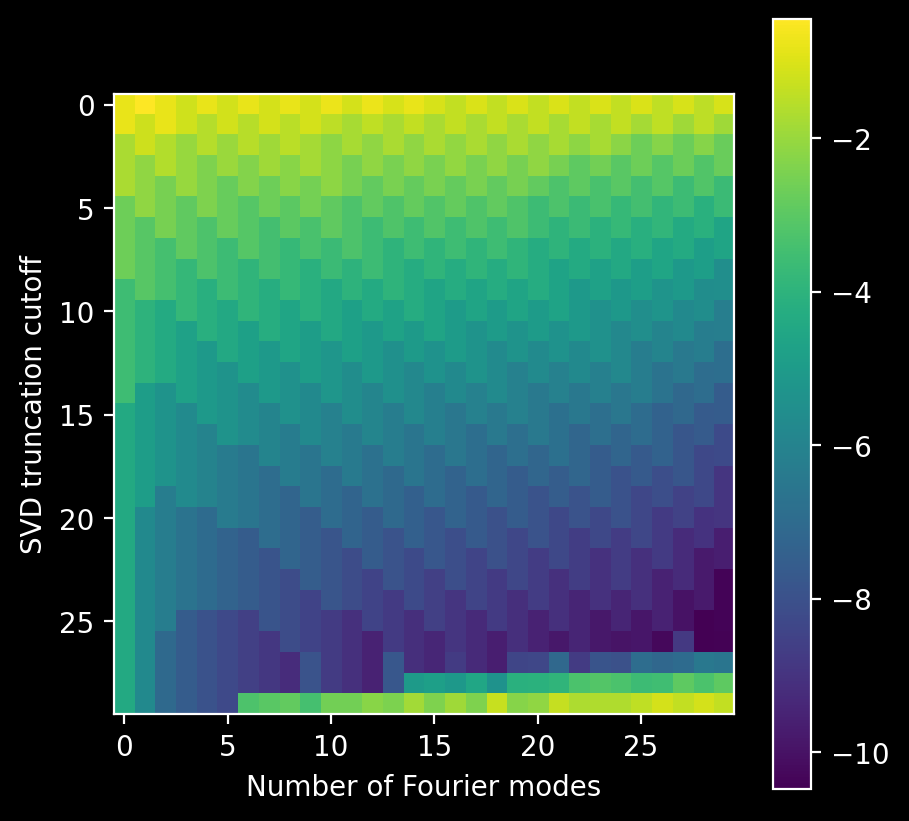

In [16]:
fig, axs = plt.subplots(figsize=(5 , 5), dpi=200)
plt.imshow(np.log10(error))
plt.colorbar()
plt.xlabel("Number of Fourier modes")
plt.ylabel("SVD truncation cutoff")
plt.show()

## Reproduce figure 11

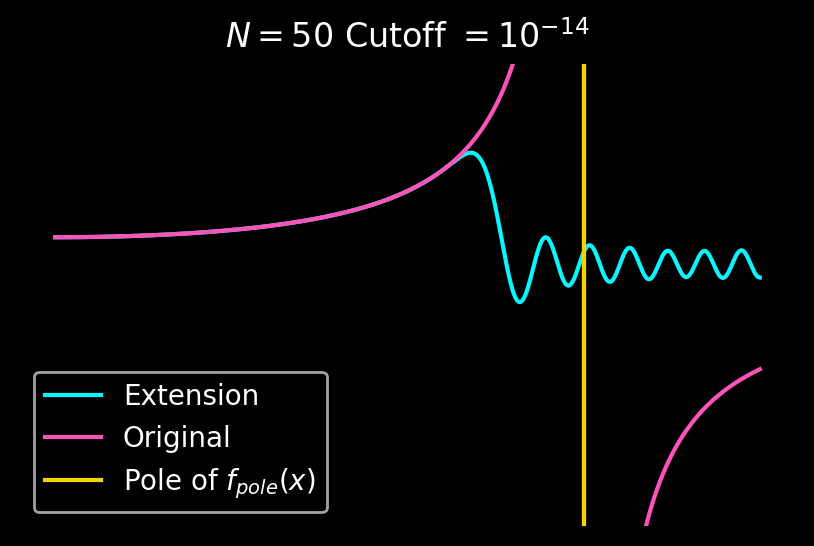

In [17]:

N     = 50
Ncoll = N
theta = np.pi
chi   = theta/2
M, x  = get_fpic_su_matrix(N, Ncoll, theta, chi)

def func(x):
    p34 = 0.75 * np.pi
    return p34 / (p34 - x) + p34 / (p34 + x)

f     = func(x)
Minv  = truncated_svd_invert(M, 1e-14)
a     = iterative_refinement(M, Minv, f, threshold = 100, maxiter = 3)

xext = np.linspace(0, theta, 1000)
frec = reconstruct(xext, a, theta)

fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
plt.title(r"$N=50$ Cutoff $=10^{-14}$")
plt.plot(xext, frec, label="Extension", c=colors[0])
plt.plot(xext, func(xext), label="Original", c=colors[1])
plt.axvline(x = 2.356, label=r"Pole of $f_{pole}(x)$", c=colors[2])
plt.ylim(-8, 8)
plt.xlabel(r"$x$")
plt.xlabel(r"$f(x)$, tilde $f(x)$")
plt.legend()
plt.axis("off")
plt.show()

## Reproduce figure 13

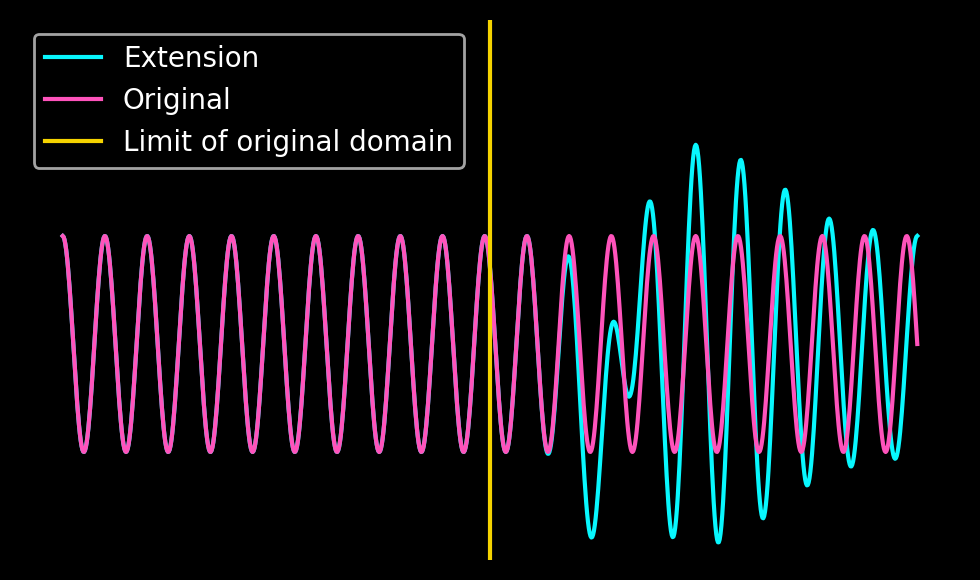

In [18]:

N     = 50
Ncoll = N
theta = np.pi
chi   = theta/2
M, x  = get_fpic_su_matrix(N, Ncoll, theta, chi)

def func(x):
    return np.cos(40.5*x)

f     = func(x)
Minv  = truncated_svd_invert(M, 1e-14)
a     = iterative_refinement(M, Minv, f, threshold = 100, maxiter = 3)

xext = np.linspace(0, theta, 1000)
frec = reconstruct(xext, a, theta)

fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
plt.plot(xext, frec, label="Extension", c=colors[0])
plt.plot(xext, func(xext), label="Original", c=colors[1])
plt.axvline(x = np.pi/2, label="Limit of original domain", c=colors[2])
plt.ylim(-2, 3)
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.savefig(f"figures/svd_ill_conditioning.png", bbox_inches='tight')
plt.show()

## Why overcollocation is good

Reproduce figure 15

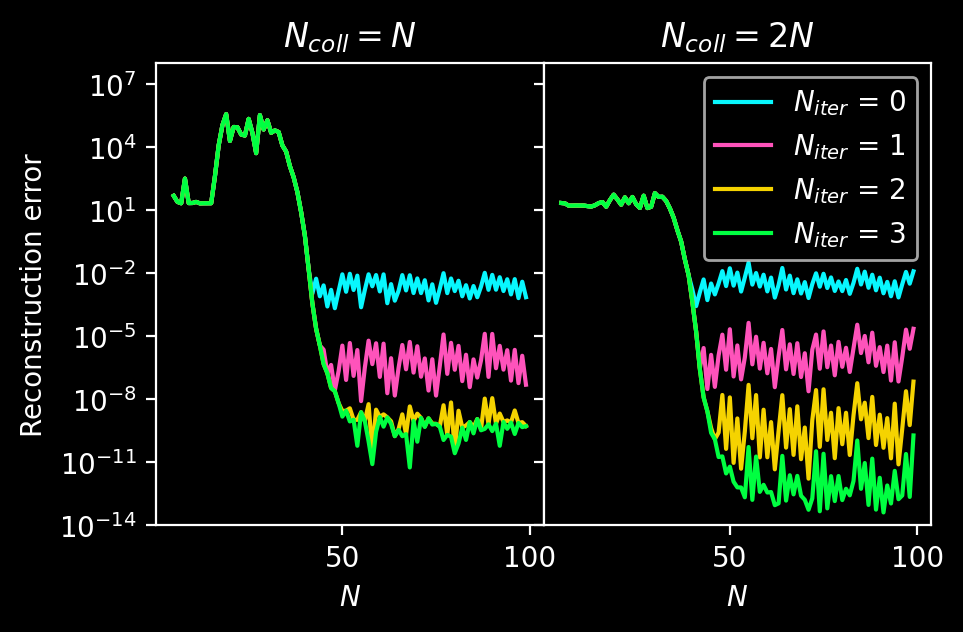

In [19]:

theta = np.pi
chi   = theta/2
xext  = np.linspace(0, theta, 1000)
ul    = np.argwhere(xext<chi)[-1][0]

def func(x):
    return np.cos(40.5*x)

fig, ax = plt.subplots(1, 2, figsize=(5, 3), dpi=200, sharey=True)
ax[0].set_title(r"$N_{coll}=N$")
ax[0].set_xlabel(r"$N$")
ax[1].set_xlabel(r"$N$")
ax[0].set_ylabel("Reconstruction error")
ax[0].set_yscale("log")
ax[0].set_ylim([1e-14, 1e8])
ax[1].set_ylim([1e-14, 1e8])
ax[1].set_title(r"$N_{coll} = 2 N$")

Ns         = np.arange(5, 100, 1)
iterations = [0, 1, 2, 3]
cutoff     = 1e-13
threshold  = 2
for axis, alpha in zip([0, 1], [1, 2]):
    for iteration in iterations:
        err = []
        for N in Ns:
            Ncoll = N * alpha
            M, x  = get_fpic_su_matrix(N, Ncoll, theta, chi)
            f     = func(x)
            Minv  = truncated_svd_invert(M, cutoff)
            a    = iterative_refinement(M, Minv, f, threshold = threshold, maxiter = iteration)
            frec = reconstruct(xext, a, theta)
            err.append(np.linalg.norm((frec - func(xext))[:ul]))

        ax[axis].plot(Ns, err, label=r"$N_{iter}$" + f" = {iteration}", c = colors[iteration])


ax[1].legend()
fig.subplots_adjust(wspace = 0)
plt.savefig(f"figures/svd_why_overcollocation.png", bbox_inches='tight')
plt.show()

# Can we just invert the collocation matrix for an arbitrary complex function?


In [20]:
def getFPICSUMatrix(N, Ncoll, theta, chi):
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N), dtype=complex)
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1)
            M[i, j] = np.exp(1j * j * np.pi / theta * x[i])
    return M, x

def invertComplexM(M, cutoff):
    U, s, Vh = scipy.linalg.svd(M)
    sinv = np.zeros(M.T.shape, dtype=complex)
    for i in range(np.min(M.shape)):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]
    return Vh.T.conjugate() @ sinv @ U.T.conjugate()

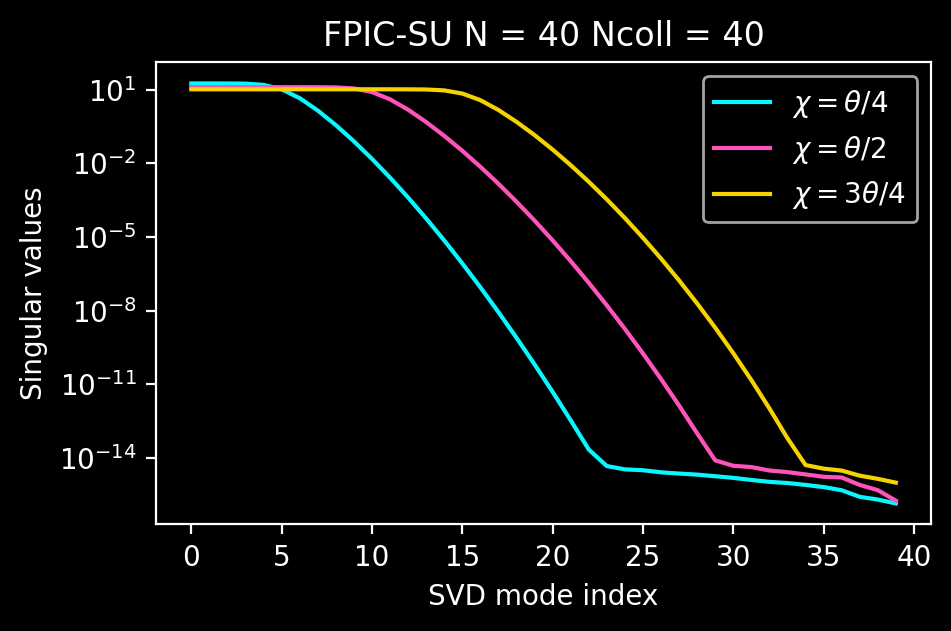

In [21]:
N     = 40
Ncoll = N

#The extended domain is split up into the physical and extension parts
#  [-theta, -chi, chi, theta]
theta = np.pi    # extension domain boundary

fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
plt.title(f"FPIC-SU N = {N} Ncoll = {Ncoll}")
plt.ylabel("Singular values")
plt.xlabel("SVD mode index")
plt.yscale("log")

chis   = [theta/4, theta/2, 3*theta/4]  # physical domain boundary
labels = [r"$\chi = \theta/4$", r"$\chi = \theta/2$", r"$\chi = 3\theta/4$"]

for i, (chi, label) in enumerate(zip(chis, labels)):
    M, x = getFPICSUMatrix(N, Ncoll, theta, chi)
    y = scipy.linalg.svdvals(M, overwrite_a=False, check_finite=True)
    x = np.arange(len(y))
    plt.plot(x, y, label=label, c=colors[i])
plt.legend()
plt.show()

Compute pseudoinverse of matrix using SVD:

For any matrix $M \in \mathbb{R}^{m\times n}$ , there exist orthogonal matrices $M \in \mathbb{R}^{m\times m}$ and $V \in \mathbb{R}^{n\times n}$ and scalars $σ_1 , . . . , σ_n$ such that
$$ M = U S V^T$$

In [22]:
chi = theta/2

M, x = getFPICSUMatrix(N, Ncoll, theta, chi)
#Factorizes the matrix a into two unitary matrices U and Vh, and a 1-D array s of singular values (real, non-negative) such that a == U @ S @ Vh, where S is a suitably shaped matrix of zeros with main diagonal s.
U, s, Vh = scipy.linalg.svd(M)

Compute pseudoinverse by inverting $S$ with cutoff

In [23]:
#Test implementation of invert M
A = np.random.rand(32, 32) + 1j * np.random.rand(32, 32)
np.testing.assert_allclose(np.abs(scipy.linalg.inv(A) - invertComplexM(A, 0)), 0, atol=1e-13)


Finally compute the periodic extension of an arbitrary complex function ($f(x) = e^x + i e^x $ in this example)

/home/xerox/.local/lib/python3.10/site-packages/matplotlib/transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


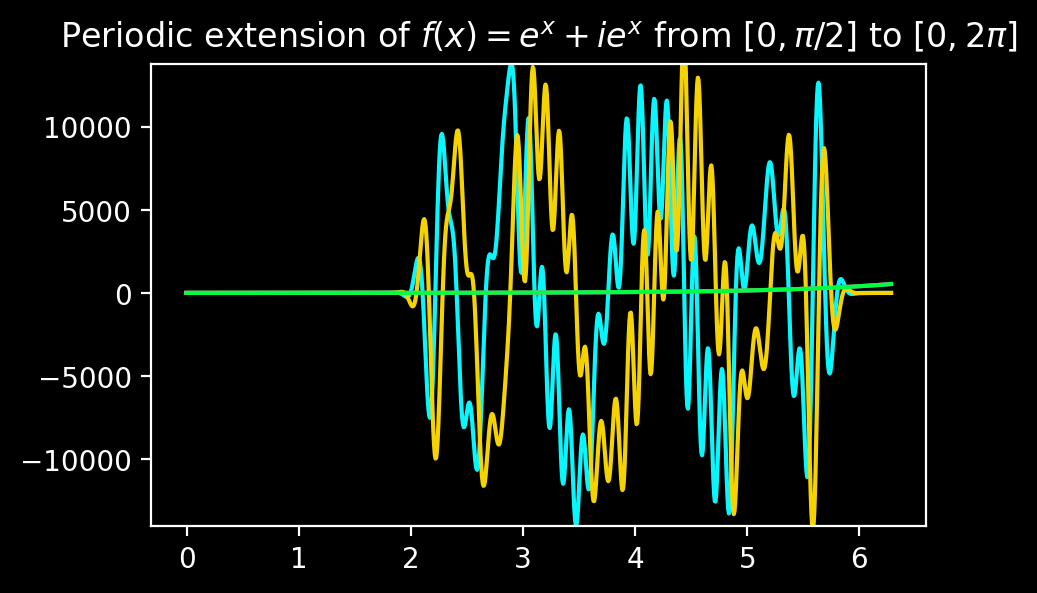

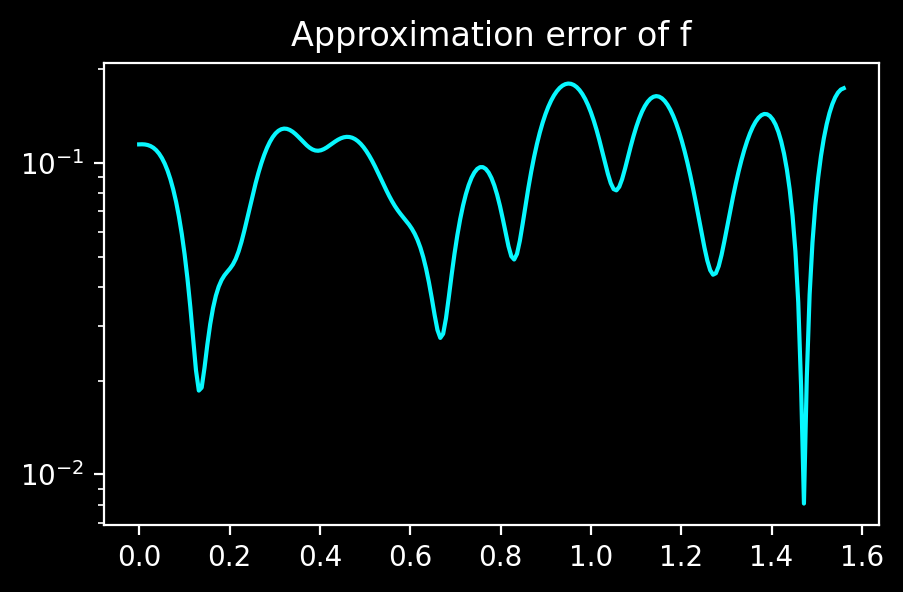

In [32]:
N     = 64
Ncoll = N
theta = np.pi
chi   = theta/2
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi)

def func(x):
    return np.exp(x) + 1j * np.exp(x)

f     = func(x)
Minv  = invertComplexM(M, 1e-14)
a     = Minv @ f

def reconstruct(x, a, theta):
    rec = np.zeros(x.shape, dtype=complex)
    for j, coeff in enumerate(a):
        rec += coeff * np.exp(1j * np.pi / theta * j * x)
    return rec

xext = np.linspace(0, 2*theta, 1000)
frec = reconstruct(xext, a, theta)

fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
plt.title(r"Periodic extension of $f(x) = e^x + i e^x$ from $[0, \pi/2]$ to $[0, 2\pi]$")
plt.plot(xext, frec.real,       c = colors[0], label="Real Extension")
plt.plot(xext, func(xext).real, c = colors[1], label="Real Original")
plt.plot(xext, frec.imag,       c = colors[2], label="Imag Extension")
plt.plot(xext, func(xext).imag, c = colors[3], label="Imag Original")
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show()
fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]), c=colors[0])
plt.show()

Improve this result by using iterative refinement

/home/xerox/.local/lib/python3.10/site-packages/matplotlib/transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


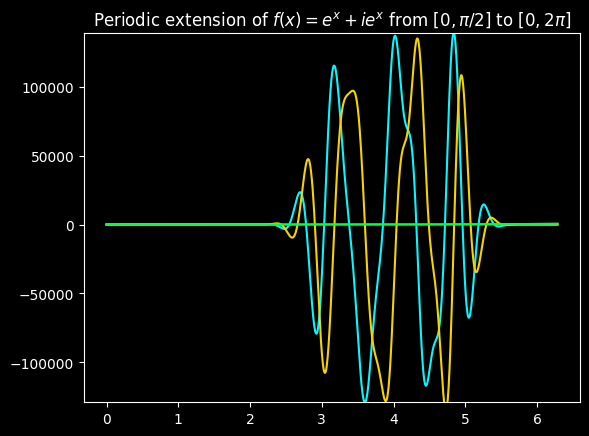

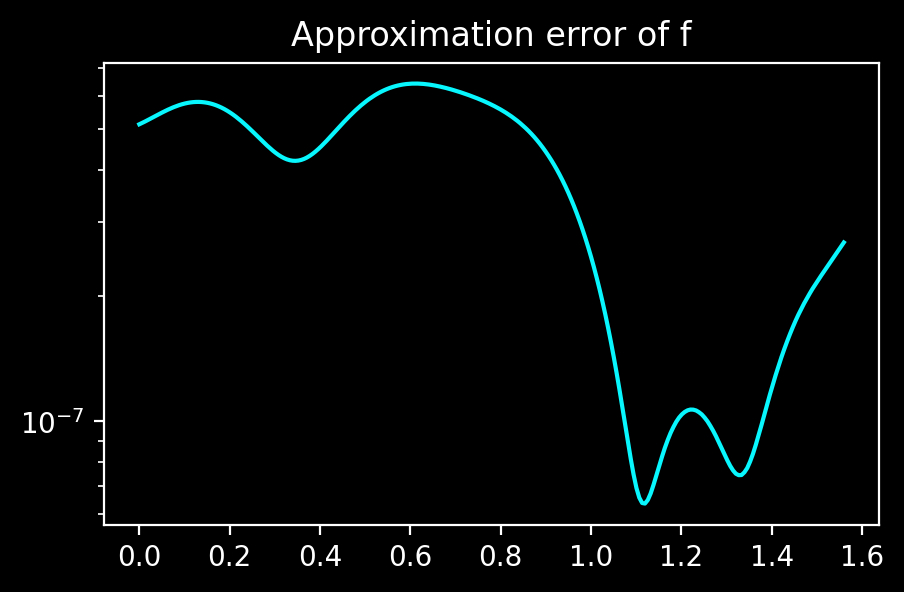

In [36]:
def iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 5):
    a       = Minv @ f
    r       = M @ a - f
    counter = 0
    while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter:
        delta    = Minv @ r
        a        = a - delta
        r        = M @ a - f
        counter += 1
    return a

Ncoll = 128
N     = 32
theta = np.pi
chi   = theta/2
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi)

def func(x):
    return np.exp(x) + 1j * np.exp(x)

f     = func(x)
Minv  = invertComplexM(M, 1e-14)
a     = iterativeRefinement(M, Minv, f, threshold = 10, maxiter = 3)

xext = np.linspace(0, 2*theta, 1000)
frec = reconstruct(xext, a, theta)

plt.title(r"Periodic extension of $f(x) = e^x + i e^x$ from $[0, \pi/2]$ to $[0, 2\pi]$")
plt.plot(xext, frec.real,       c = colors[0], label="Real Extension")
plt.plot(xext, func(xext).real, c = colors[1], label="Real Original")
plt.plot(xext, frec.imag,       c = colors[2], label="Imag Extension")
plt.plot(xext, func(xext).imag, c = colors[3], label="Imag Original")
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show()
fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]), c=colors[0])
plt.show()

We see that decomposition into plane waves works in principle but leads to very large function values in the extension domain, strong oscillatory behaviour and less than ideal reconstruction of the original function. 

### Can we get a better result by splitting everything into symmetric and antisymmetric parts and doing 4 real SVDs?

/home/xerox/.local/lib/python3.10/site-packages/matplotlib/transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


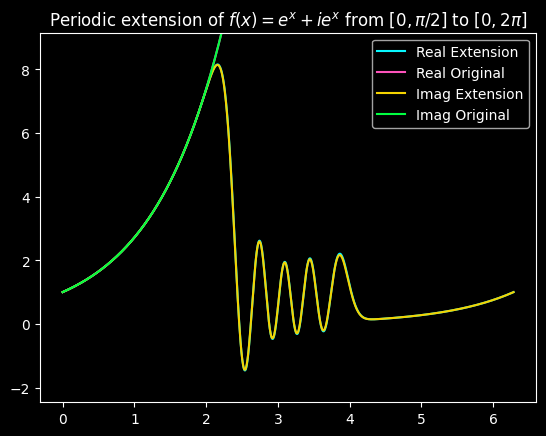

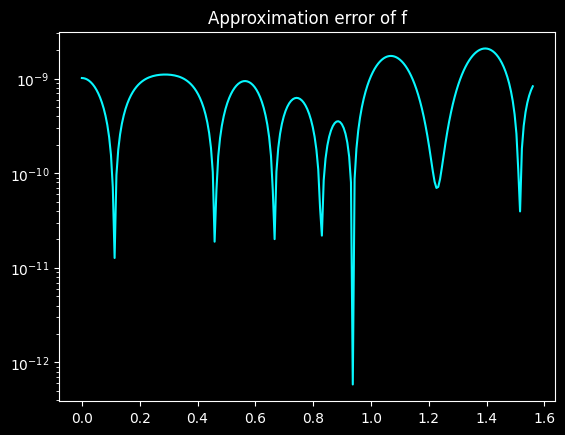

In [38]:
def getFPICSUEvenMatrix(N, Ncoll, theta, chi):
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N))
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1)
            M[i, j] = np.cos(j * np.pi / theta * x[i])
    return M, x

def getFPICSUOddMatrix(N, Ncoll, theta, chi):
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N))
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1)
            M[i, j] = np.sin(j * np.pi / theta * x[i])
    return M, x

def invertRealM(M, cutoff):
    U, s, Vh = scipy.linalg.svd(M)
    sinv = np.zeros(M.T.shape)
    for i in range(np.min(M.shape)):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]
    return Vh.T @ sinv @ U.T


def reconstructOdd(x, a, theta):
    rec = np.zeros(x.shape)
    for j, coeff in enumerate(a):
        rec += coeff * np.sin(np.pi / theta * j * x)
    return rec

def reconstructEven(x, a, theta):
    rec = np.zeros(x.shape)
    for j, coeff in enumerate(a):
        rec += coeff * np.cos(np.pi / theta * j * x)
    return rec

def iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 5):
    a       = Minv @ f
    r       = M @ a - f
    counter = 0
    while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter:
        delta    = Minv @ r
        a        = a - delta
        r        = M @ a - f
        counter += 1
    return a


N     = 32
Ncoll = N * 2
theta = np.pi
chi   = theta/2
Meven, x  = getFPICSUEvenMatrix(N, Ncoll, theta, chi)
Modd,  x  = getFPICSUOddMatrix (N, Ncoll, theta, chi)

def func(x):
    return np.exp(x) + 1j * np.exp(x)

Meveninv  = invertRealM(Meven, 1e-14)
Moddinv   = invertRealM(Modd,  1e-14)


xext = np.linspace(0, 2*theta, 1000)

f      = func(x)
feven  = (func(x) + func(-x)).real/2
fodd   = (func(x) - func(-x)).real/2
aeven  = iterativeRefinement(Meven, Meveninv, feven, threshold = 10, maxiter = 3)
aodd   = iterativeRefinement(Modd,  Moddinv,  fodd,  threshold = 10, maxiter = 3)
freal  = reconstructOdd(xext, aodd, theta) + reconstructEven(xext, aeven, theta)
feven  = (func(x) + func(-x)).imag/2
fodd   = (func(x) - func(-x)).imag/2
aeven  = iterativeRefinement(Meven, Meveninv, feven, threshold = 10, maxiter = 10)
aodd   = iterativeRefinement(Modd,  Moddinv,  fodd,  threshold = 10, maxiter = 10)
fimag  = reconstructOdd(xext, aodd, theta) + reconstructEven(xext, aeven, theta)
frec   = freal + 1j * fimag

plt.title(r"Periodic extension of $f(x) = e^x + i e^x$ from $[0, \pi/2]$ to $[0, 2\pi]$")
plt.plot(xext, frec.real,       c = colors[0], label="Real Extension")
plt.plot(xext, func(xext).real, c = colors[1], label="Real Original")
plt.plot(xext, frec.imag,       c = colors[2], label="Imag Extension")
plt.plot(xext, func(xext).imag, c = colors[3], label="Imag Original")
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show()
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]), c=colors[0])
plt.show()

## The all-in-one solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from mpmath import *
mp.dps = 64
eps = 1e-64

class FourierExtension:
    def __init__(self, N, Ncoll, theta, chi, cutoff):
        self.N, self.Ncoll, self.theta, self.chi, self.cutoff = N, Ncoll, theta, chi, cutoff
        self.Meven = self.getFPICSUEvenMatrix(N, Ncoll, theta, chi)
        self.Modd  = self.getFPICSUOddMatrix (N, Ncoll, theta, chi)

        self.dx    = chi / (Ncoll - 1)
        self.x     = np.arange(-Ncoll + 1, Ncoll) * self.dx


        self.Meveninv  = self.invertRealM(self.Meven, cutoff)
        self.Moddinv   = self.invertRealM(self.Modd,  cutoff)

    def getX(self):
        return self.x, self.dx

    def getFPICSUEvenMatrix(self, N, Ncoll, theta, chi):
        M  = np.zeros((Ncoll, N))
        dx = chi / (Ncoll - 1)
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                M[i, j] = np.cos(j * np.pi / theta * i * dx)
        return M

    def getFPICSUOddMatrix(self, N, Ncoll, theta, chi):
        M = np.zeros((Ncoll, N))
        dx = chi / (Ncoll - 1)
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                M[i, j] = np.sin(j * np.pi / theta * i * dx)
        return M

    def invertRealM(self, M, cutoff):
        U, s, Vh = scipy.linalg.svd(M)
        sinv = np.zeros(M.T.shape)
        for i in range(np.min(M.shape)):
            if s[i] < cutoff:
                sinv[i, i] = 0
            else:
                sinv[i, i] = 1/s[i]
        return Vh.T @ sinv @ U.T


    def convertToFourierCoeff(self, aodd, aeven):
        k = np.arange(-self.N, self.N) * np.pi / self.theta
        fhat = np.zeros(2*self.N, dtype=complex)

        for j, (oddcoeff, evecoeff) in enumerate(zip(aodd, aeven)):
            fhat[ j + self.N] +=   oddcoeff / (2j) + evecoeff / (2)
            fhat[-j + self.N] += - oddcoeff / (2j) + evecoeff / (2)


        return np.fft.ifftshift(fhat), np.fft.ifftshift(k)

    def reconstructFourier(self, x, fhat, derivative_order = 0):
        rec  = np.zeros (   x.shape, dtype=complex)
        ks   = np.fft.ifftshift(np.arange( -self.N, self.N) * np.pi / self.theta)
        for k, coeff in zip(ks, fhat):
            rec += coeff * (1j * k) ** derivative_order * np.exp(1j * k * x)
        return rec

    def iterativeRefinement(self, M, Minv, f, threshold = 100, maxiter = 5):
        a       = Minv @ f
        r       = M @ a - f
        counter = 0
        while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter:
            delta    = Minv @ r
            a        = a - delta
            r        = M @ a - f
            counter += 1
        return a

    def computeExtension(self, f, Ni, threshold = 10, maxiter = 3):
        refeven  = ((f + np.flip(f)).real/2)[self.Ncoll-1:]
        refodd   = ((f - np.flip(f)).real/2)[self.Ncoll-1:]
        imfeven  = ((f + np.flip(f)).imag/2)[self.Ncoll-1:]
        imfodd   = ((f - np.flip(f)).imag/2)[self.Ncoll-1:]
        aeven    = self.iterativeRefinement(self.Meven, self.Meveninv, refeven, threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Meven, self.Meveninv, imfeven, threshold = threshold, maxiter = maxiter)
        aodd     = self.iterativeRefinement(self.Modd,  self.Moddinv,  refodd,  threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Modd,  self.Moddinv,  imfodd,  threshold = threshold, maxiter = maxiter)
        #frec     = self.reconstructOdd(xext, aodd, self.theta) + self.reconstructEven(xext, aeven, self.theta)
        fhat, k  = self.convertToFourierCoeff(aodd, aeven)
        frec     = self.fourierInterpolation(fhat, Ni)
        return frec, fhat

    def fourierInterpolation(self, fhat, Ni):
        N = len(fhat)
        Npad = int(Ni/2 - N/2)
        ft   = np.fft.fftshift(fhat)
        ft_pad = np.concatenate([np.zeros(Npad), ft, np.zeros(Npad)])
        fint = scipy.fft.ifft(np.fft.fftshift(ft_pad), norm="forward")
        return fint

    def rescaleToPhysical(self, x, getSlope = False):
        a = x[0]
        b = x[-1]
        L = b -a
        sx = ( x - a ) / L
        sx = sx * (2*self.chi) - self.chi
        if getSlope:

            return sx, a * 2 * chi / L + chi, 2 * chi / L
        else:
            return sx

    def rescaleToExtended(self, x, getSlope = False):
        a = x[0]
        b = x[-1]
        sx = ( x - a ) / ( b - a )
        sx = sx * (2*self.theta) - self.theta
        if getSlope:
            return sx, a, b - a
        else:
            return sx

    def plotApproximationErorr(self, xext, forg, frec):
        plt.title("Approximation error of f")
        plt.yscale("log")
        plt.plot(xext, np.abs(forg - frec))
        plt.show()


NameError: name 'colors' is not defined

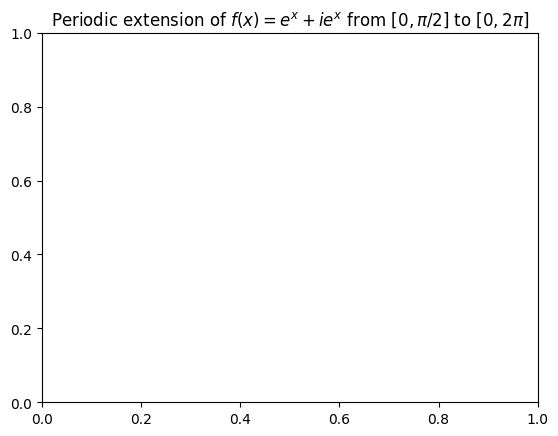

In [2]:
def func(x):
    return np.exp(x) + 1j * np.exp(x)

#Start with f on arbitrary domain with even number of points
x = np.linspace(0, 2, 128)
L0 = x[ 0]
L1 = x[-2]
f = func(x)

Ncoll = int((len(x))/2) #x = 0 and 31 points in each direction
N     = int(Ncoll/2)
theta = np.pi
chi   = theta/2
cutoff = 1e-14

fext = FourierExtension( N, Ncoll, theta, chi, cutoff = cutoff)


xext = x[:-1]#np.linspace(L0, L1, 128)
frec, fhat = fext.computeExtension(f[:-1], len(x), maxiter=10)
frec       = fext.reconstructFourier(fext.rescaleToPhysical(x[:-1]), fhat)
forg = f[:-1]
plt.title(r"Periodic extension of $f(x) = e^x + i e^x$ from $[0, \pi/2]$ to $[0, 2\pi]$")
plt.plot(xext, frec.real,       c = colors[0], label="Real Extension")
plt.plot(xext, func(xext).real, c = colors[1], label="Real Original")
plt.plot(xext, frec.imag,       c = colors[2], label="Imag Extension")
plt.plot(xext, func(xext).imag, c = colors[3], label="Imag Original")
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show()

fext.plotApproximationErorr(xext, forg, frec)

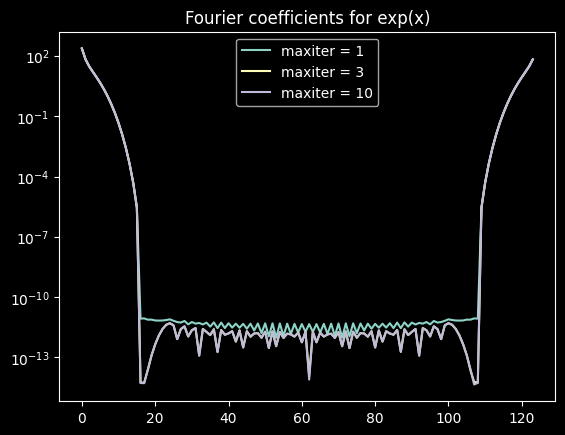

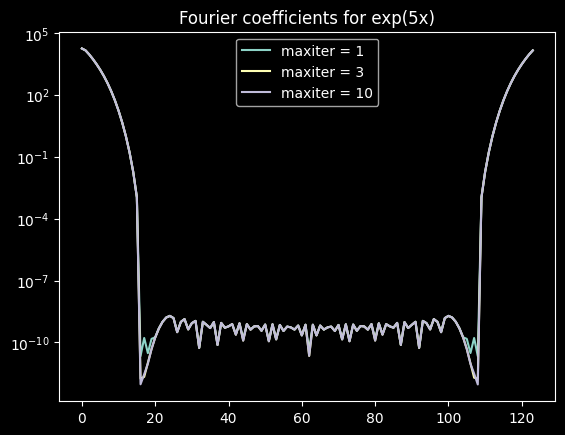

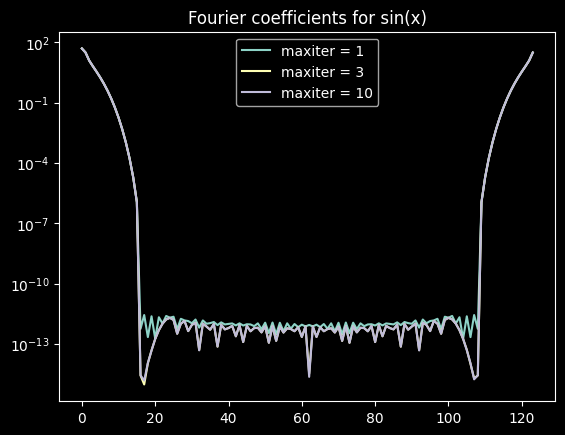

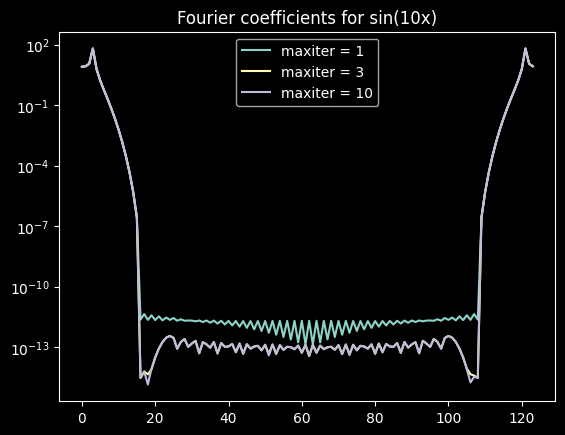

In [29]:

def get_k(p, dx):
    """
    Calculate the k values for a given array and spacing.

    Args:
        p (numpy.ndarray): The input array.
        dx (float): The spacing between points.

    Returns:
        numpy.ndarray: The k values.
    """
    N = len(p)
    L = N * dx
    k = 2 * np.pi / L * np.arange(-N / 2, N / 2)
    return np.fft.ifftshift(k)

def getExtendedFunction(f, x, NNcollRatio = 0.5, cutoff = 1e-14, maxiter = 3, replaceByRealValues = True ):
    Nfull = len(x)
    Ncoll = int((len(x))/2) #x = 0 and 31 points in each direction
    N     = int(Ncoll * NNcollRatio)
    theta = np.pi
    chi   = theta/2

    fext = FourierExtension( N, Ncoll, theta, chi, cutoff = cutoff)

    xscale, shift, slope = fext.rescaleToPhysical(x[:-1], getSlope=True)
    dx                   = xscale[1] - xscale[0]
    xint                 = np.pad(xscale, (0, Nfull), mode="linear_ramp", end_values=(0, xscale[-1] + Nfull * dx))
    xext                 = (xint + shift)/slope
    frec, fhat           = fext.computeExtension(f[:-1], (len(x)-2)*2, maxiter=maxiter)
    frec                 = np.roll(frec, Ncoll - 1)

    if replaceByRealValues:
        frec[:Nfull-1] = f[:-1]
    return xext, frec

x = np.linspace(0, 1, 64)
dx = x[1]-x[0]
fs = [np.exp(x), np.exp(5*x), np.sin(x), np.sin(x*10)]
ns = ["exp(x)", "exp(5x)", "sin(x)", "sin(10x)"]

for f, n in zip(fs, ns):
    plt.title(f"Fourier coefficients for {n}")
    plt.yscale("log")
    for maxiter in [1, 3, 10]:
        xext, fext = getExtendedFunction(f, x, maxiter=maxiter, NNcollRatio=.5)
        k    = get_k(fext, dx)
        fhat = scipy.fft.fft(fext)
        plt.plot(np.abs(fhat), label=f"maxiter = {maxiter}")
    plt.legend()
    plt.show()

NameError: name 'getExtendedFunction' is not defined

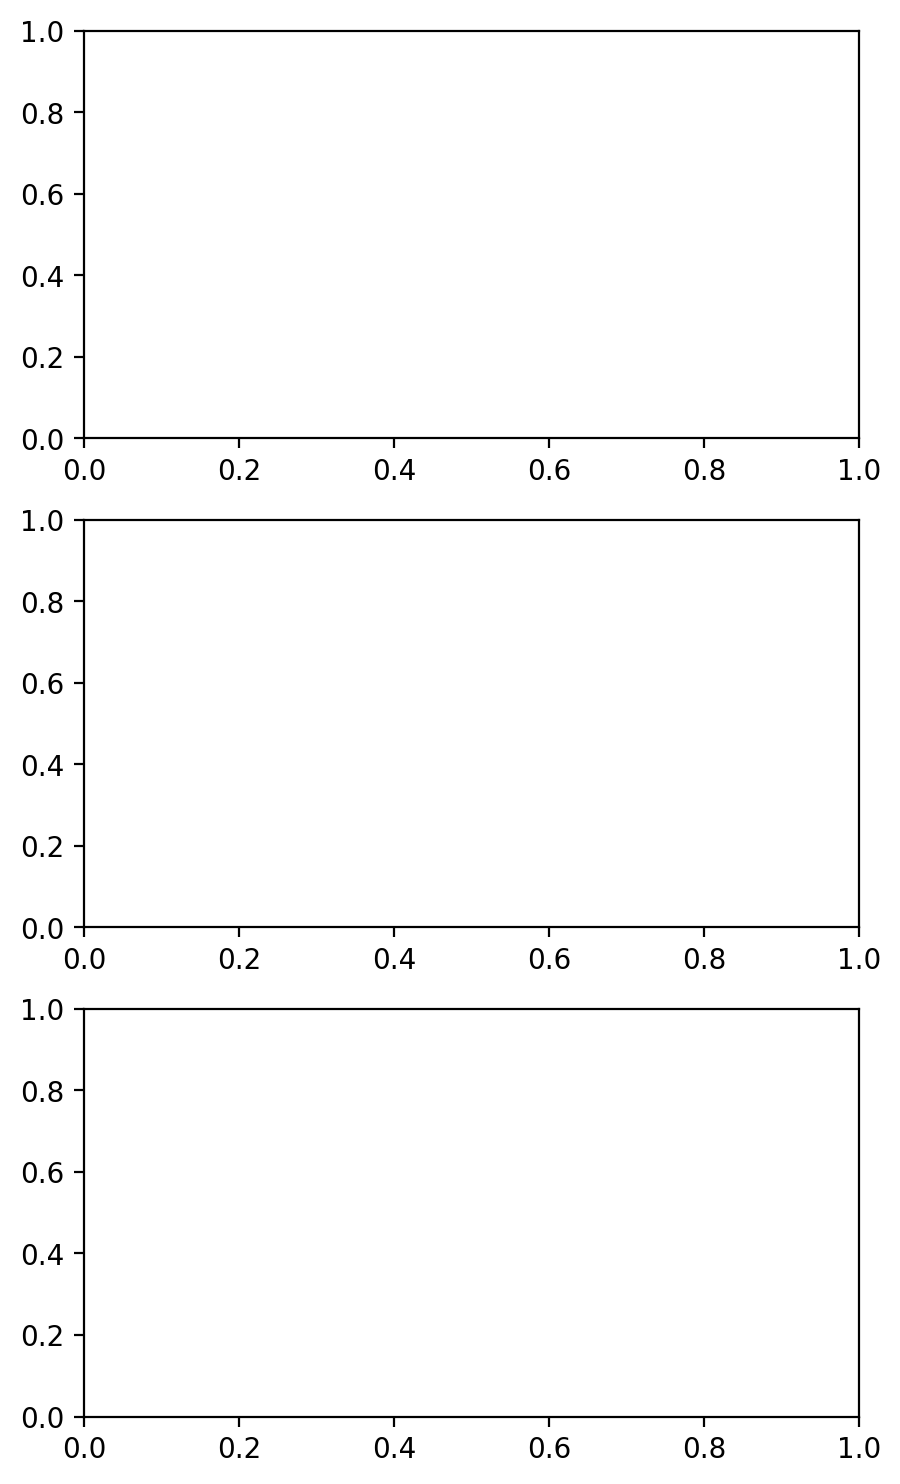

In [4]:

# Number of subplots
num_subplots = 3

# Create subplots
fig, axs = plt.subplots(num_subplots, 1,  figsize=(5 , 3* num_subplots), dpi=200)


def get_k(p, dx):
    """
    Calculate the k values for a given array and spacing.

    Args:
        p (numpy.ndarray): The input array.
        dx (float): The spacing between points.

    Returns:
        numpy.ndarray: The k values.
    """
    N = len(p)
    L = N * dx
    k = 2 * np.pi / L * np.arange(-N / 2, N / 2)
    return np.fft.ifftshift(k)

def func(x):
    return np.exp(x)



L  = np.pi
N  = 100
dx = L/(N - 1)
x  = np.arange(N) * dx

f  = func(x)

xext, fext = getExtendedFunction(f, x, maxiter=10, NNcollRatio=.5)
f_hat = scipy.fft.fft(fext)

# Get the k values
k    = get_k(f_hat, dx)
xorg = x
forg = func(x)

# Loop through different subtraction orders
for i, o in enumerate([2, 4, 8]):
    frec = scipy.fft.ifft(f_hat * (1j * k) ** o).real  # Use only the first N elements (the original domain)
    frec = frec[:N]

    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].get_xaxis().set_ticks([])
    axs[i].get_yaxis().set_ticks([])

    # Plot the sum and the original function in subplots
    axs[i].set_title(f"Derivative order {o} with L1 error {np.mean(np.abs(frec - forg)):3.3e}")
    axs[i].plot(xorg, frec, label="Reconstructed Derivative", c = colors[0])
    axs[i].plot(xorg, forg, label="Original", c = colors[1])
    axs[i].legend()

# Adjust layout
fig.tight_layout()
fig.savefig("figures/svd_accuracy.png", bbox_inches='tight')
